In [ ]:
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


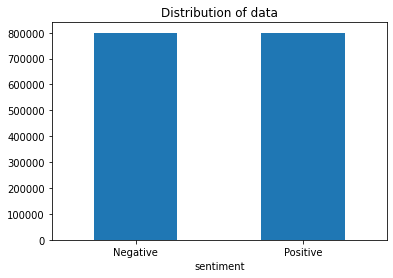

In [ ]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/gdrive/My Drive/MIProject/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [ ]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText


In [ ]:
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state = 0)

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



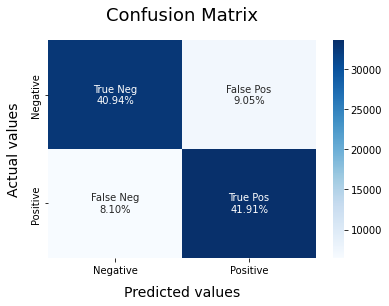

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [ ]:
file = open('/content/gdrive/My Drive/MIProject/Models/vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('/content/gdrive/My Drive/MIProject/Models/Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

In [ ]:
def predict(vectoriser, model, data):
    # Predict the sentiment
    text = []
    text.append(data)
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    return sentiment[0]

In [ ]:
!unzip gdrive/MyDrive/MIProject/BBCNewsSummary.zip

In [ ]:
import os
import time
import glob
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
articles_path = './BBC News Summary/News Articles'
summaries_path = './BBC News Summary/Summaries'
categories_list = ['politics', 'sport', 'tech', 'entertainment', 'business']

In [ ]:
def read_files_from_folders(articles_path, summaries_path, categories_list = ['tech', 'sport'], encoding = 'ISO-8859-1'):
    articles = []
    summaries = []
    categories = []
    for category in categories_list:
        article_paths = glob.glob(os.path.join(articles_path, category, '*.txt'), recursive = True)
        summary_paths = glob.glob(os.path.join(summaries_path, category, '*.txt'), recursive = True)
        
        print(f'found {len(article_paths)} files in articles/{category} folder, {len(summary_paths)} files in summaries/{category}')
        
        if(len(article_paths)!=len(summary_paths)):
            print('Number of files not equal')
            return
    

        for idx_file in range(len(article_paths)):
            categories.append(category)
            with open(article_paths[idx_file], mode='r', encoding = encoding) as file:
                articles.append(file.read())

            with open(summary_paths[idx_file], mode='r', encoding = encoding) as file:
                summaries.append(file.read()) 

    print(f'total {len(articles)} files in articles folders, {len(summaries)} files in summaries folders')
    return articles, summaries, categories

In [ ]:
articles, summaries, categories = read_files_from_folders(articles_path, summaries_path, categories_list)

found 417 files in articles/politics folder, 417 files in summaries/politics
found 511 files in articles/sport folder, 511 files in summaries/sport
found 401 files in articles/tech folder, 401 files in summaries/tech
found 386 files in articles/entertainment folder, 386 files in summaries/entertainment
found 510 files in articles/business folder, 510 files in summaries/business
total 2225 files in articles folders, 2225 files in summaries folders


In [ ]:
df = pd.DataFrame({'articles': articles, 'summaries': summaries, 'category': categories},)
df

,articles,summaries,category
0,Police urge pub closure power\n\nNew powers ar...,The new licensing laws will give police greate...,politics
1,MPs issued with Blackberry threat\n\nMPs will ...,MPs will be thrown out of the Commons if they ...,politics
2,Clarke plans migrant point scheme\n\nAnyone pl...,Anyone planning to move to the UK will have to...,politics
3,US casino 'tricks' face ban in UK\n\nControver...,A spokesman for the British Casino Association...,politics
4,Jack Cunningham to stand down\n\nVeteran Labou...,Veteran Labour MP and former Cabinet minister ...,politics
...,...,...,...
2220,News Corp makes $5.4bn Fox offer\n\nNews Corpo...,"Under the terms of the offer, minority Fox sha...",business
2221,German jobless rate at new record\n\nMore than...,"And ILO-based figures also suggest that 14,000...",business
2222,Dollar hits new low versus euro\n\nThe US doll...,The US dollar has continued its record-breakin...,business
2223,Five million Germans out of work\n\nGermany's ...,Germany's unemployment figure rose above the p...,business


In [ ]:
def form_and_save_sentiment_csv(categories_list):
  for i in categories_list:
    sentiment_df = df.loc[df['category'] == i]
    sentiment_df['articles_sentiment'] = df.apply(lambda x: predict(vectoriser, LRmodel, x['articles']), axis=1)
    sentiment_df['summary_sentiment'] = df.apply(lambda x: predict(vectoriser, LRmodel, x['summaries']), axis=1)
    # sentiment_df.to_csv('/content/gdrive/My Drive/MIProject/LRmodel/sentiment_{name}.csv'.format(name = i))

In [ ]:
form_and_save_sentiment_csv(categories_list)